In [1]:
import pandas as pd
import numpy as np

from sklearn.cluster import DBSCAN, OPTICS
from sklearn import preprocessing
from sklearn.decomposition import PCA


import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

In [2]:
data = pd.read_csv('CC GENERAL.csv').iloc[:,1:].dropna()

## DBSCAN

In [3]:
# 2. Так как разные признаки лежат в разных шкалах, то стандартизируем данные


data = np.array(data, dtype='float')

min_max_scaler = preprocessing.StandardScaler()
scaled_data = min_max_scaler.fit_transform(data)

In [4]:
# 3. Проведем кластеризацию методов DBSCAN при параметрах по умолчанию.
# Выведем метки кластеров, количество кластеров, 
# а также процент наблюдений, которые кластеризовать не удалось


clustering = DBSCAN().fit(scaled_data)

print(set(clustering.labels_))
print(len(set(clustering.labels_)) - 1)
print(list(clustering.labels_).count(-1) / len(list(clustering.labels_)))

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, -1}
36
0.7512737378415933


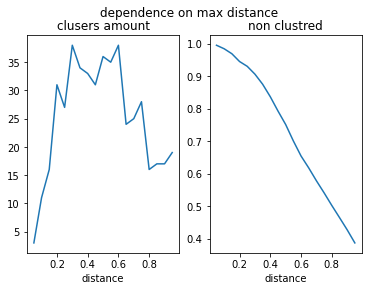

In [42]:
# 4. Постройте график количества кластеров и процента 
# не кластеризованных наблюдений в зависимости от максимальной
# рассматриваемой дистанции между наблюдениями.
# Минимальное значение количества точек образующих, кластер оставить по
# умолчанию


clusters_amount = []
non_clustered = []
eps_distances = []

for max_distance in np.arange(0.05, 1, 0.05):
    clustering = DBSCAN(eps=max_distance).fit(scaled_data)
    
    clusters_amount.append(len(set(clustering.labels_)) - 1)
    non_clustered.append(list(clustering.labels_).count(-1) / len(list(clustering.labels_)))
    eps_distances.append(max_distance)

fig, axs = plt.subplots(1, 2)
fig.suptitle("dependence on max distance")

axs[0].plot(eps_distances, clusters_amount)
axs[0].set_title('clusers amount')
axs[0].set_xlabel("distance")

axs[1].plot(eps_distances, non_clustered)
axs[1].set_title('non clustred')
axs[1].set_xlabel("distance")


plt.show()

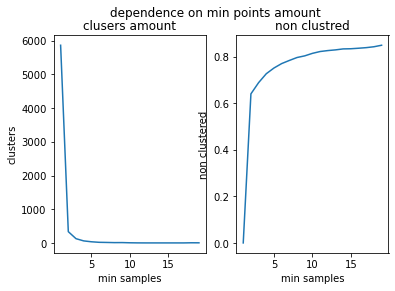

In [43]:
# 5. Постройте график количества кластеров и процента 
# не кластеризованных наблюдений в зависимости 
# от минимального значения количества точек, образующих кластер.
# Максимальную рассматриваемую дистанцию между наблюдениями оставьте по
# умолчанию

clusters_amount = []
non_clustered = []
min_samples_ = []

for min_samples in range(1, 20):
    clustering = DBSCAN(min_samples=min_samples).fit(scaled_data)
    
    clusters_amount.append(len(set(clustering.labels_)) - 1)
    non_clustered.append(list(clustering.labels_).count(-1) / len(list(clustering.labels_)))
    min_samples_.append(min_samples)

fig, axs = plt.subplots(1, 2)
fig.suptitle("dependence on min points amount")

axs[0].plot(min_samples_, clusters_amount)
axs[0].set_title('clusers amount')
axs[0].set_xlabel("min samples")
axs[0].set_ylabel("clusters")

axs[1].plot(min_samples_, non_clustered)
axs[1].set_title('non clustred')
axs[1].set_xlabel("min samples")
axs[1].set_ylabel("non clustered")


plt.show()

In [26]:
# 6. Определите значения параметров, при котором количество кластеров 
# получается от 5 до 7, и процент не кластеризованных 
# наблюдений не превышает 12%.


breakpoint = False
for max_distance in np.arange(1.25, 2, 0.25):
    for min_samples in range(3, 10):
        clustering = DBSCAN(eps=max_distance, min_samples=min_samples, n_jobs=-1).fit(scaled_data)
        
        percent_non_clustered = list(clustering.labels_).count(-1) / len(list(clustering.labels_))
        total_clusters = len(set(clustering.labels_)) - 1
        
        if percent_non_clustered <= .12 and total_clusters in [5, 6, 7]:
            print(f"Min samples = {min_samples}::eps={max_distance}")
            breakpoint = True
            break
    if breakpoint:
            break


Min samples = 4::eps=1.75


In [30]:
clustering = DBSCAN(eps=1.75, min_samples=4, n_jobs=-1).fit(scaled_data)
        
percent_non_clustered = list(clustering.labels_).count(-1) / len(list(clustering.labels_))
total_clusters = len(set(clustering.labels_)) - 1

print(percent_non_clustered, total_clusters)

0.09506716072255673 5


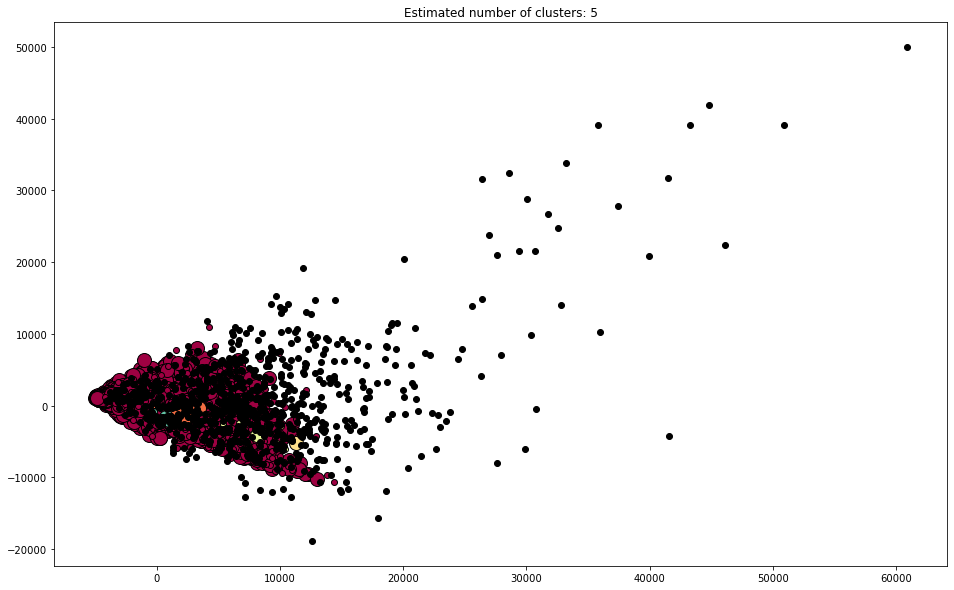

In [31]:
# 7. Понизьте размерность данных до 2 используя метод главных компонент.
# Визуализируйте результаты кластеризации полученные 
# в пункте 6 (метки должны быть получены на данных до уменьшения размерности).


pca = PCA(n_components=2)
pca_data = pca.fit_transform(data)

labels = clustering.labels_
n_clusters = len(set(clustering.labels_)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)
core_samples_mask = np.zeros_like(clustering.labels_, dtype=bool)
core_samples_mask[clustering.core_sample_indices_] = True


unique_labels = set(labels)
colors = [
    plt.cm.Spectral(each)
    for each in np.linspace(0, 1, len(unique_labels))
]

ss = preprocessing.StandardScaler()
X = ss.fit_transform(data)

plt.figure(figsize=(16, 10))

for k, col in zip(unique_labels, colors):
    if k == -1:
        col = [0,0,0,1]
    
    class_member_mask = (labels == k)
    
    xy = pca_data[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    xy = pca_data[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)


plt.title('Estimated number of clusters: %d' % n_clusters)
plt.show()

# y_pred = clustering.fit_predict(X)
# plt.scatter(X[:, 0], X[:, 1], c=y_pred, cmap='Paired')
# plt.show()

## OPTICS

In [6]:
# 2. Найдите такие параметры метода OPTICS (*max_eps *и min_samples), чтобы
# получить результаты близкие к результатам DBSCAN из пункта 6

breakpoint = False
for max_distance in np.arange(2, 4, 0.25):
    for min_samples in range(3, 15):
        clustering = OPTICS(
            max_eps=max_distance, 
            min_samples=min_samples,
            metric='euclidean',
            cluster_method='dbscan',
            n_jobs=-1
        ).fit(scaled_data)
        
        percent_non_clustered = list(clustering.labels_).count(-1) / len(list(clustering.labels_))
        total_clusters = len(set(clustering.labels_)) - 1

        if percent_non_clustered <= .12 and total_clusters in [5, 6, 7]:
            print(f"Min samples = {min_samples}::eps={max_distance}")
            breakpoint = True
            break
    if breakpoint:
            break


Min samples = 3::eps=2.0


In [32]:
clustering = OPTICS(
            max_eps=2, 
            min_samples=3,
#             metric='euclidean',
            cluster_method='dbscan',
            n_jobs=-1
        ).fit(scaled_data)

percent_non_clustered = list(clustering.labels_).count(-1) / len(list(clustering.labels_))
total_clusters = len(set(clustering.labels_)) - 1

print(percent_non_clustered, total_clusters)

0.06310792033348772 6


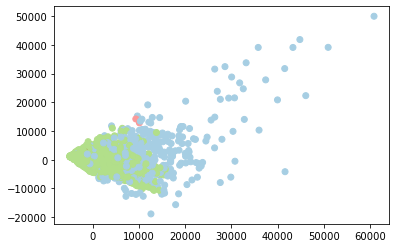

In [37]:
# 3. Визуализируйте полученный результат


y_pred = clustering.fit_predict(scaled_data)
plt.scatter(pca_data[:, 0], pca_data[:, 1], c=y_pred, cmap='Paired')
plt.show()

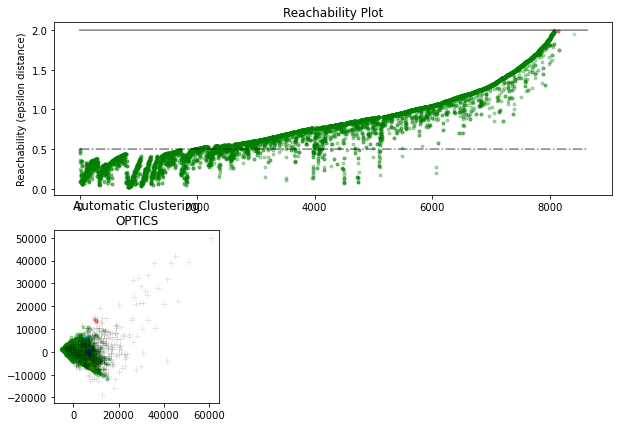

In [38]:
# а также постройге график достижимости (reachable plot)

plt.figure(figsize=(10, 7))
G = gridspec.GridSpec(2, 3)
ax1 = plt.subplot(G[0, :])
ax2 = plt.subplot(G[1, 0])


clust = clustering
X = pca_data[:]
space = np.arange(len(X))
reachability = clustering.reachability_[clustering.ordering_]
labels = clustering.labels_[clustering.ordering_]


colors = ['g.', 'r.', 'b.', 'y.', 'c.', 'olive']
for klass, color in zip(range(0, 5), colors):
    Xk = space[labels == klass]
    Rk = reachability[labels == klass]
    ax1.plot(Xk, Rk, color, alpha=0.3)
ax1.plot(space[labels == -1], reachability[labels == -1], 'k.', alpha=0.3)
ax1.plot(space, np.full_like(space, 2., dtype=float), 'k-', alpha=0.5)
ax1.plot(space, np.full_like(space, 0.5, dtype=float), 'k-.', alpha=0.5)
ax1.set_ylabel('Reachability (epsilon distance)')
ax1.set_title('Reachability Plot')

colors = ['g.', 'r.', 'b.', 'y.', 'c.', 'olive']
for klass, color in zip(range(0, 6), colors):
    Xk = X[clust.labels_ == klass]
    ax2.plot(Xk[:, 0], Xk[:, 1], color, alpha=0.3)
ax2.plot(X[clust.labels_ == -1, 0], X[clust.labels_ == -1, 1], 'k+', alpha=0.1)
ax2.set_title('Automatic Clustering\nOPTICS')

plt.show()

In [39]:
from collections import Counter

Counter(clustering.labels_)

Counter({0: 8077, -1: 545, 1: 3, 2: 3, 3: 3, 4: 2, 5: 3})

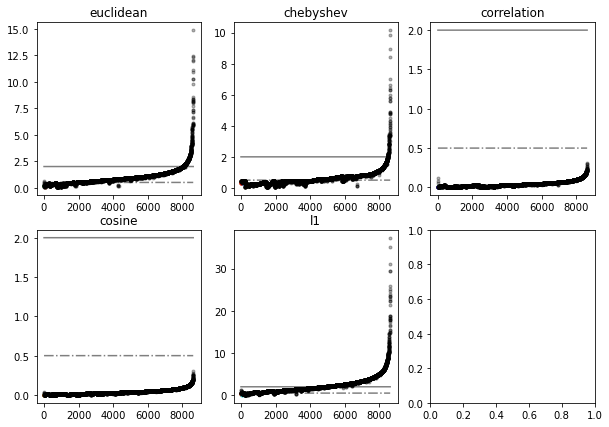

In [51]:
plt.figure(figsize=(10, 7))
G = gridspec.GridSpec(2, 3)
ax1 = plt.subplot(G[0, 0])
ax2 = plt.subplot(G[1, 0])
ax3 = plt.subplot(G[0, 1])
ax4 = plt.subplot(G[0, 2])
ax5 = plt.subplot(G[1, 1])
ax6 = plt.subplot(G[1, 2])

axes_ = [ax1, ax2, ax3, ax4, ax5]

metrics = ['euclidean', 'cosine', 'chebyshev', 'correlation', 'l1']
colors = ['g.', 'r.', 'b.', 'y.', 'c.', 'olive']
X = pca_data[:]
space = np.arange(len(X))


for metric in metrics:
    
    clust = OPTICS(
        metric=metric,
        n_jobs=-1
    ).fit(scaled_data)
    
    reachability = clust.reachability_[clust.ordering_]
    labels = clust.labels_[clust.ordering_]

    for klass, color in zip(range(0, 5), colors):
        Xk = space[labels == klass]
        Rk = reachability[labels == klass]
        axes_[metrics.index(metric)].plot(Xk, Rk, color, alpha=0.3)
    axes_[metrics.index(metric)].plot(space[labels == -1], reachability[labels == -1], 'k.', alpha=0.3)
    axes_[metrics.index(metric)].plot(space, np.full_like(space, 2., dtype=float), 'k-', alpha=0.5)
    axes_[metrics.index(metric)].plot(space, np.full_like(space, 0.5, dtype=float), 'k-.', alpha=0.5)
    axes_[metrics.index(metric)].set_title(f'{metric}')
#     for klass, color in zip(range(0, 6), colors):
#         Xk = X[clust.labels_ == klass]
#         axes_[metrics.index(metric)].plot(Xk[:, 0], Xk[:, 1], color, alpha=0.3)
#     axes_[metrics.index(metric)].plot(X[clust.labels_ == -1, 0], X[clust.labels_ == -1, 1], 'k+', alpha=0.1)
#     axes_[metrics.index(metric)].set_title(f'{metric}')

plt.show()